In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors

In [2]:
chemtastesdb_df = pd.read_excel("../data/ChemTastesDB_database.xlsx",
                                na_values=["*"],
                                keep_default_na=True)
chemtastesdb_df = chemtastesdb_df.iloc[:-3][["Name", "canonical SMILES", "Class taste"]]
print(chemtastesdb_df.info())
chemtastesdb_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              4075 non-null   object
 1   canonical SMILES  4075 non-null   object
 2   Class taste       4075 non-null   object
dtypes: object(3)
memory usage: 95.6+ KB
None


,Name,canonical SMILES,Class taste
4070,WS23,CCNC(=O)C(C)(C(C)C)C(C)C,Miscellaneous
4071,WS3,CCNC(=O)C1CC(C)CCC1C(C)C,Miscellaneous
4072,YYGSNSA,CC(NC(=O)C(CO)NC(=O)C(CC(N)=O)NC(=O)C(CO)NC(=O...,Miscellaneous
4073,α-Hydroxy sanshool,CC=CC=CC=CCCC=CC(=O)NCC(C)(C)O,Miscellaneous
4074,γ-Linolenic acid,CCCCCC=CCC=CCC=CCCCCC(O)=O,Miscellaneous


In [3]:
chemtastesdb_df.isnull().sum()

Name                0
canonical SMILES    0
Class taste         0
dtype: int64

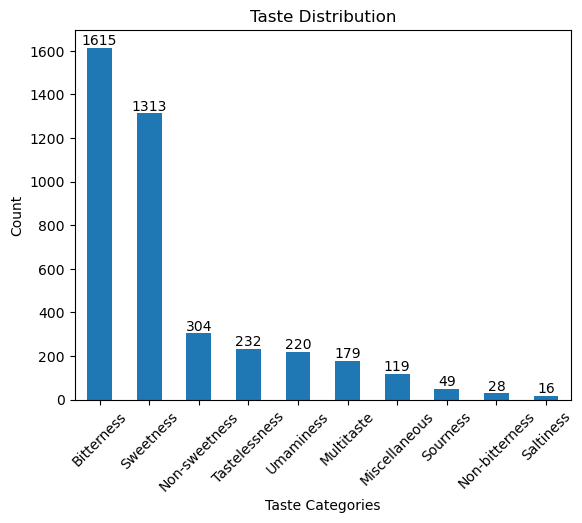

In [4]:
taste_count = chemtastesdb_df["Class taste"].value_counts(dropna=False)

ax = taste_count.plot(kind="bar", title="Taste Distribution")

for i, count in enumerate(taste_count):
    ax.text(i, count, str(count), ha="center", va="bottom")

ax.set_xlabel("Taste Categories")
ax.set_ylabel("Count")
ax.set_xticklabels(taste_count.index.fillna("NA"), rotation=45)

plt.show()

In [5]:
unwanted_tastes = ["Miscellaneous", "Multitaste"]
chemtastesdb_df = chemtastesdb_df[~chemtastesdb_df["Class taste"].isin(unwanted_tastes)]

In [6]:
chemtastesdb_df

,Name,canonical SMILES,Class taste
0,(-)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness
1,(+)-4β-hydroxyhernandulcin,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Sweetness
2,(+)-Dihydroquercetin 3-acetate,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Sweetness
3,(+)-Dihydro-6-methoxy-luteolin 3-acetate,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Sweetness
4,(+)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness
...,...,...,...
3951,D-Ribulose,OCC(O)C(O)C(=O)CO,Non-bitterness
3952,Fucoidan,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Non-bitterness
3953,Melibiose,OCC1OC(OCC2OC(O)C(O)C(O)C2O)C(O)C(O)C1O,Non-bitterness
3954,Rutamarin,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Non-bitterness


In [96]:
chemtastesdb_df_bitter = chemtastesdb_df.copy()
chemtastesdb_df_bitter["Class taste"] = chemtastesdb_df_bitter[
    "Class taste"].apply(lambda x: "Bitterness"
                         if x == "Bitterness" else "Non-bitterness")

In [97]:
def get_features(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None

    features = {
        "MW": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumRings": rdMolDescriptors.CalcNumRings(mol),
        "NumAromaticRings": Lipinski.NumAromaticRings(mol)
    }

    return features

def get_element_count(smiles):
    mol = Chem.MolFromSmiles(smiles)
    element_counts = defaultdict(int)

    if mol is None:
        return None

    for atom in mol.GetAtoms():
        element = atom.GetSymbol()
        element_counts[element] += 1

    return dict(element_counts)

In [98]:
feature_list = chemtastesdb_df["canonical SMILES"].apply(get_features)
features_df = pd.DataFrame(feature_list.tolist(), index=chemtastesdb_df_bitter.index)
chemtastesdb_df_bitter = pd.concat([chemtastesdb_df_bitter, features_df],
                                   axis=1)

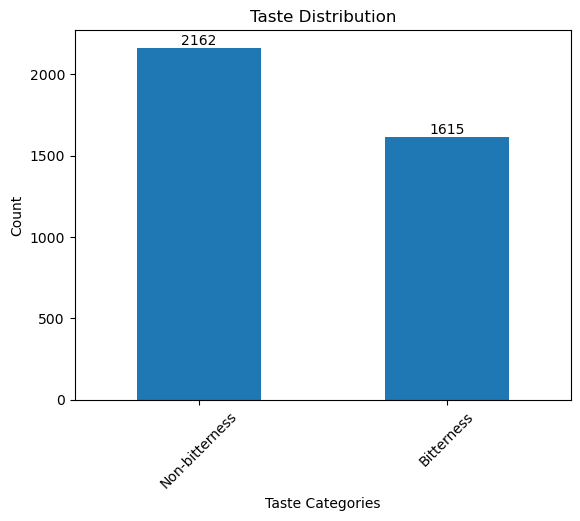

In [99]:
b_taste_count = chemtastesdb_df_bitter["Class taste"].value_counts(dropna=False)

ax = b_taste_count.plot(kind="bar", title="Taste Distribution")

for i, count in enumerate(b_taste_count):
    ax.text(i, count, str(count), ha="center", va="bottom")

ax.set_xlabel("Taste Categories")
ax.set_ylabel("Count")
ax.set_xticklabels(b_taste_count.index.fillna("NA"), rotation=45)

plt.show()

In [100]:
chemtastesdb_df_bitter["Element counts"] = chemtastesdb_df_bitter["canonical SMILES"].apply(get_element_count)

In [101]:
def get_fg_count(smiles):
    mol = Chem.MolFromSmiles(smiles)
    functional_group_counts = defaultdict(int)

    if mol is None:
        return None
    
    descriptors = Descriptors.CalcMolDescriptors(mol)

    for desc_name, desc_value in descriptors.items():
        if desc_name.startswith("fr_") and desc_value > 0:
            functional_group_counts[desc_name[3:]] += 1
    
    return dict(functional_group_counts)

In [ ]:
chemtastesdb_df_bitter["Functional group counts"] = chemtastesdb_df_bitter["canonical SMILES"].apply(get_fg_count)

In [ ]:
all_functional_groups = set()
for counts in chemtastesdb_df_bitter["Functional group counts"].dropna():
    all_functional_groups.update(counts.keys())

for fg in sorted(all_functional_groups):
    chemtastesdb_df_bitter[f"fg_{fg}"] = chemtastesdb_df_bitter["Functional group counts"].apply(lambda x: x.get(fg, 0))

chemtastesdb_df_bitter.tail()

,Name,canonical SMILES,Class taste,MW,LogP,HBA,HBD,TPSA,NumRings,NumAromaticRings,...,fg_sulfide,fg_sulfonamd,fg_sulfone,fg_term_acetylene,fg_tetrazole,fg_thiazole,fg_thiocyan,fg_thiophene,fg_unbrch_alkane,fg_urea
3951,D-Ribulose,OCC(O)C(O)C(=O)CO,Non-bitterness,150.130,-2.7381,5,4,97.99,0,0,...,0,0,0,0,0,0,0,0,0,0
3952,Fucoidan,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Non-bitterness,242.249,-1.2966,6,3,113.29,1,0,...,0,0,0,0,0,0,0,0,0,0
3953,Melibiose,OCC1OC(OCC2OC(O)C(O)C(O)C2O)C(O)C(O)C1O,Non-bitterness,342.297,-5.3972,11,8,189.53,2,0,...,0,0,0,0,0,0,0,0,0,0
3954,Rutamarin,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Non-bitterness,356.418,3.9018,5,0,65.74,3,2,...,0,0,0,0,0,0,0,0,0,0
3955,Volemitol,OCC(O)C(O)C(O)C(O)C(O)CO,Non-bitterness,212.198,-4.2245,7,7,141.61,0,0,...,0,0,0,0,0,0,0,0,0,0


Class taste  Bitterness  Non-bitterness Functional group
0                   424             942           Al_COO
1                   499             645            Al_OH
2                   454             625     Al_OH_noTert
3                    27              52              ArN
4                    40              47           Ar_COO
..                  ...             ...              ...
75                   10              27         thiazole
76                    1               0         thiocyan
77                    1               3        thiophene
78                  110              99    unbrch_alkane
79                   31              92             urea

[80 rows x 3 columns]


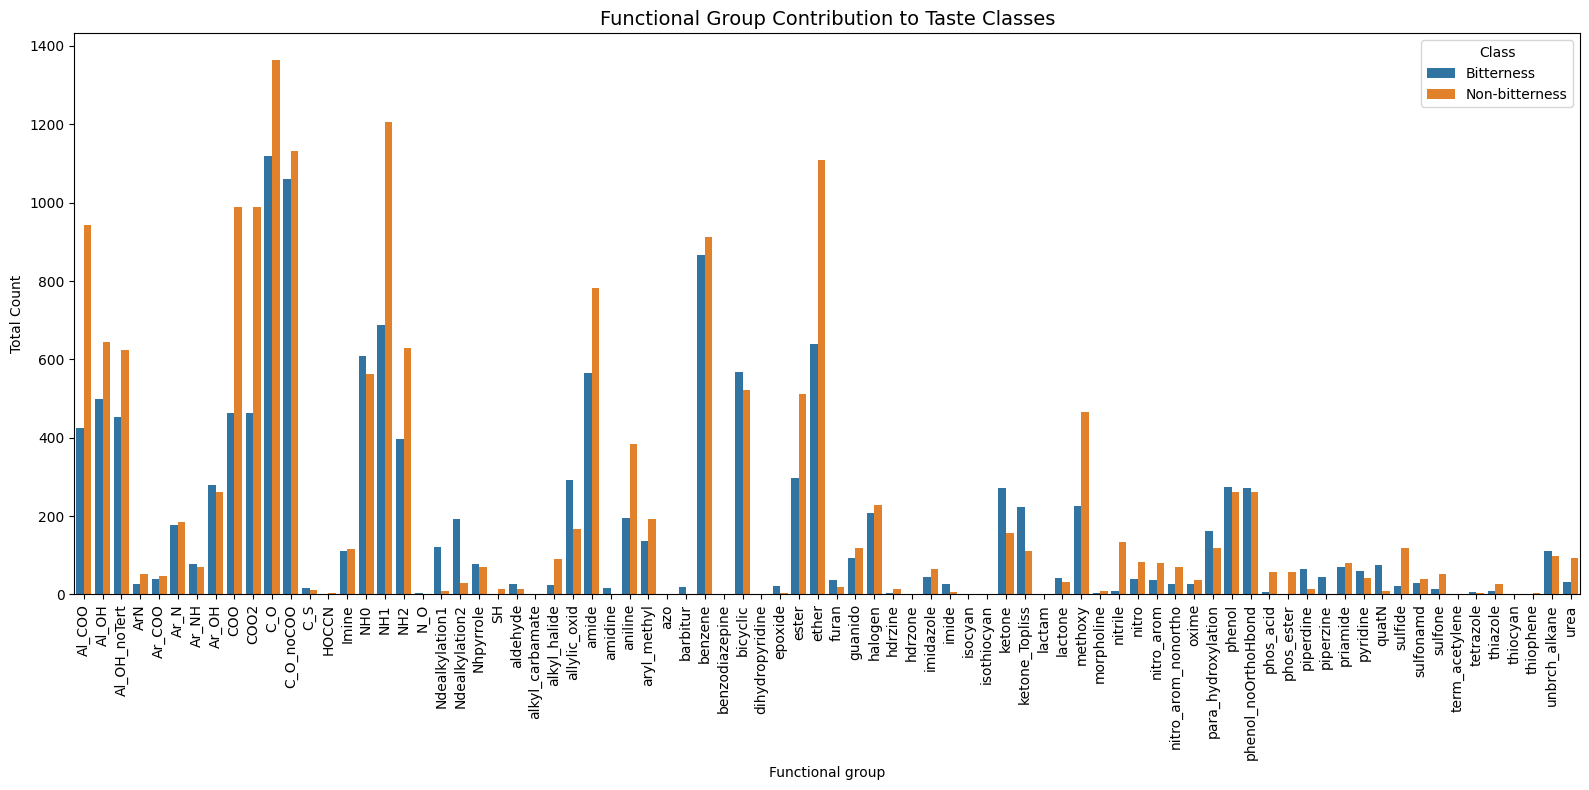

In [ ]:
fg_totals = chemtastesdb_df_bitter.groupby("Class taste")[[col for col in chemtastesdb_df_bitter.columns if "fg_" in col]].sum()

fg_totals = fg_totals.T.reset_index()
fg_totals["Functional group"] = fg_totals["index"].str.replace("fg_", "")
fg_totals = fg_totals.drop(columns="index")

df_melted = pd.melt(
    fg_totals, 
    id_vars="Functional group", 
    value_vars=["Bitterness", "Non-bitterness"],
    var_name="Class", 
    value_name="Total Count"
)

plt.figure(figsize=(16, 8))

ax = sns.barplot(
    data=df_melted,
    x="Functional group",
    y="Total Count",
    hue="Class"
)

print(fg_totals)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Functional Group Contribution to Taste Classes", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from rdkit.Chem import Descriptors

mol = Chem.MolFromSmiles("CC1OC(C)C(OS(O)(=O)=O)C(O)C1O")
descriptors = Descriptors.CalcMolDescriptors(mol)
descriptors

for desc_name, desc_value in descriptors.items():
    if desc_name.startswith("fr_"):
        print(f"- {desc_name}: {int(desc_value)}")

- fr_Al_COO: 0
- fr_Al_OH: 2
- fr_Al_OH_noTert: 2
- fr_ArN: 0
- fr_Ar_COO: 0
- fr_Ar_N: 0
- fr_Ar_NH: 0
- fr_Ar_OH: 0
- fr_COO: 0
- fr_COO2: 0
- fr_C_O: 0
- fr_C_O_noCOO: 0
- fr_C_S: 0
- fr_HOCCN: 0
- fr_Imine: 0
- fr_NH0: 0
- fr_NH1: 0
- fr_NH2: 0
- fr_N_O: 0
- fr_Ndealkylation1: 0
- fr_Ndealkylation2: 0
- fr_Nhpyrrole: 0
- fr_SH: 0
- fr_aldehyde: 0
- fr_alkyl_carbamate: 0
- fr_alkyl_halide: 0
- fr_allylic_oxid: 0
- fr_amide: 0
- fr_amidine: 0
- fr_aniline: 0
- fr_aryl_methyl: 0
- fr_azide: 0
- fr_azo: 0
- fr_barbitur: 0
- fr_benzene: 0
- fr_benzodiazepine: 0
- fr_bicyclic: 0
- fr_diazo: 0
- fr_dihydropyridine: 0
- fr_epoxide: 0
- fr_ester: 0
- fr_ether: 1
- fr_furan: 0
- fr_guanido: 0
- fr_halogen: 0
- fr_hdrzine: 0
- fr_hdrzone: 0
- fr_imidazole: 0
- fr_imide: 0
- fr_isocyan: 0
- fr_isothiocyan: 0
- fr_ketone: 0
- fr_ketone_Topliss: 0
- fr_lactam: 0
- fr_lactone: 0
- fr_methoxy: 0
- fr_morpholine: 0
- fr_nitrile: 0
- fr_nitro: 0
- fr_nitro_arom: 0
- fr_nitro_arom_nonortho: 0
- fr_ni

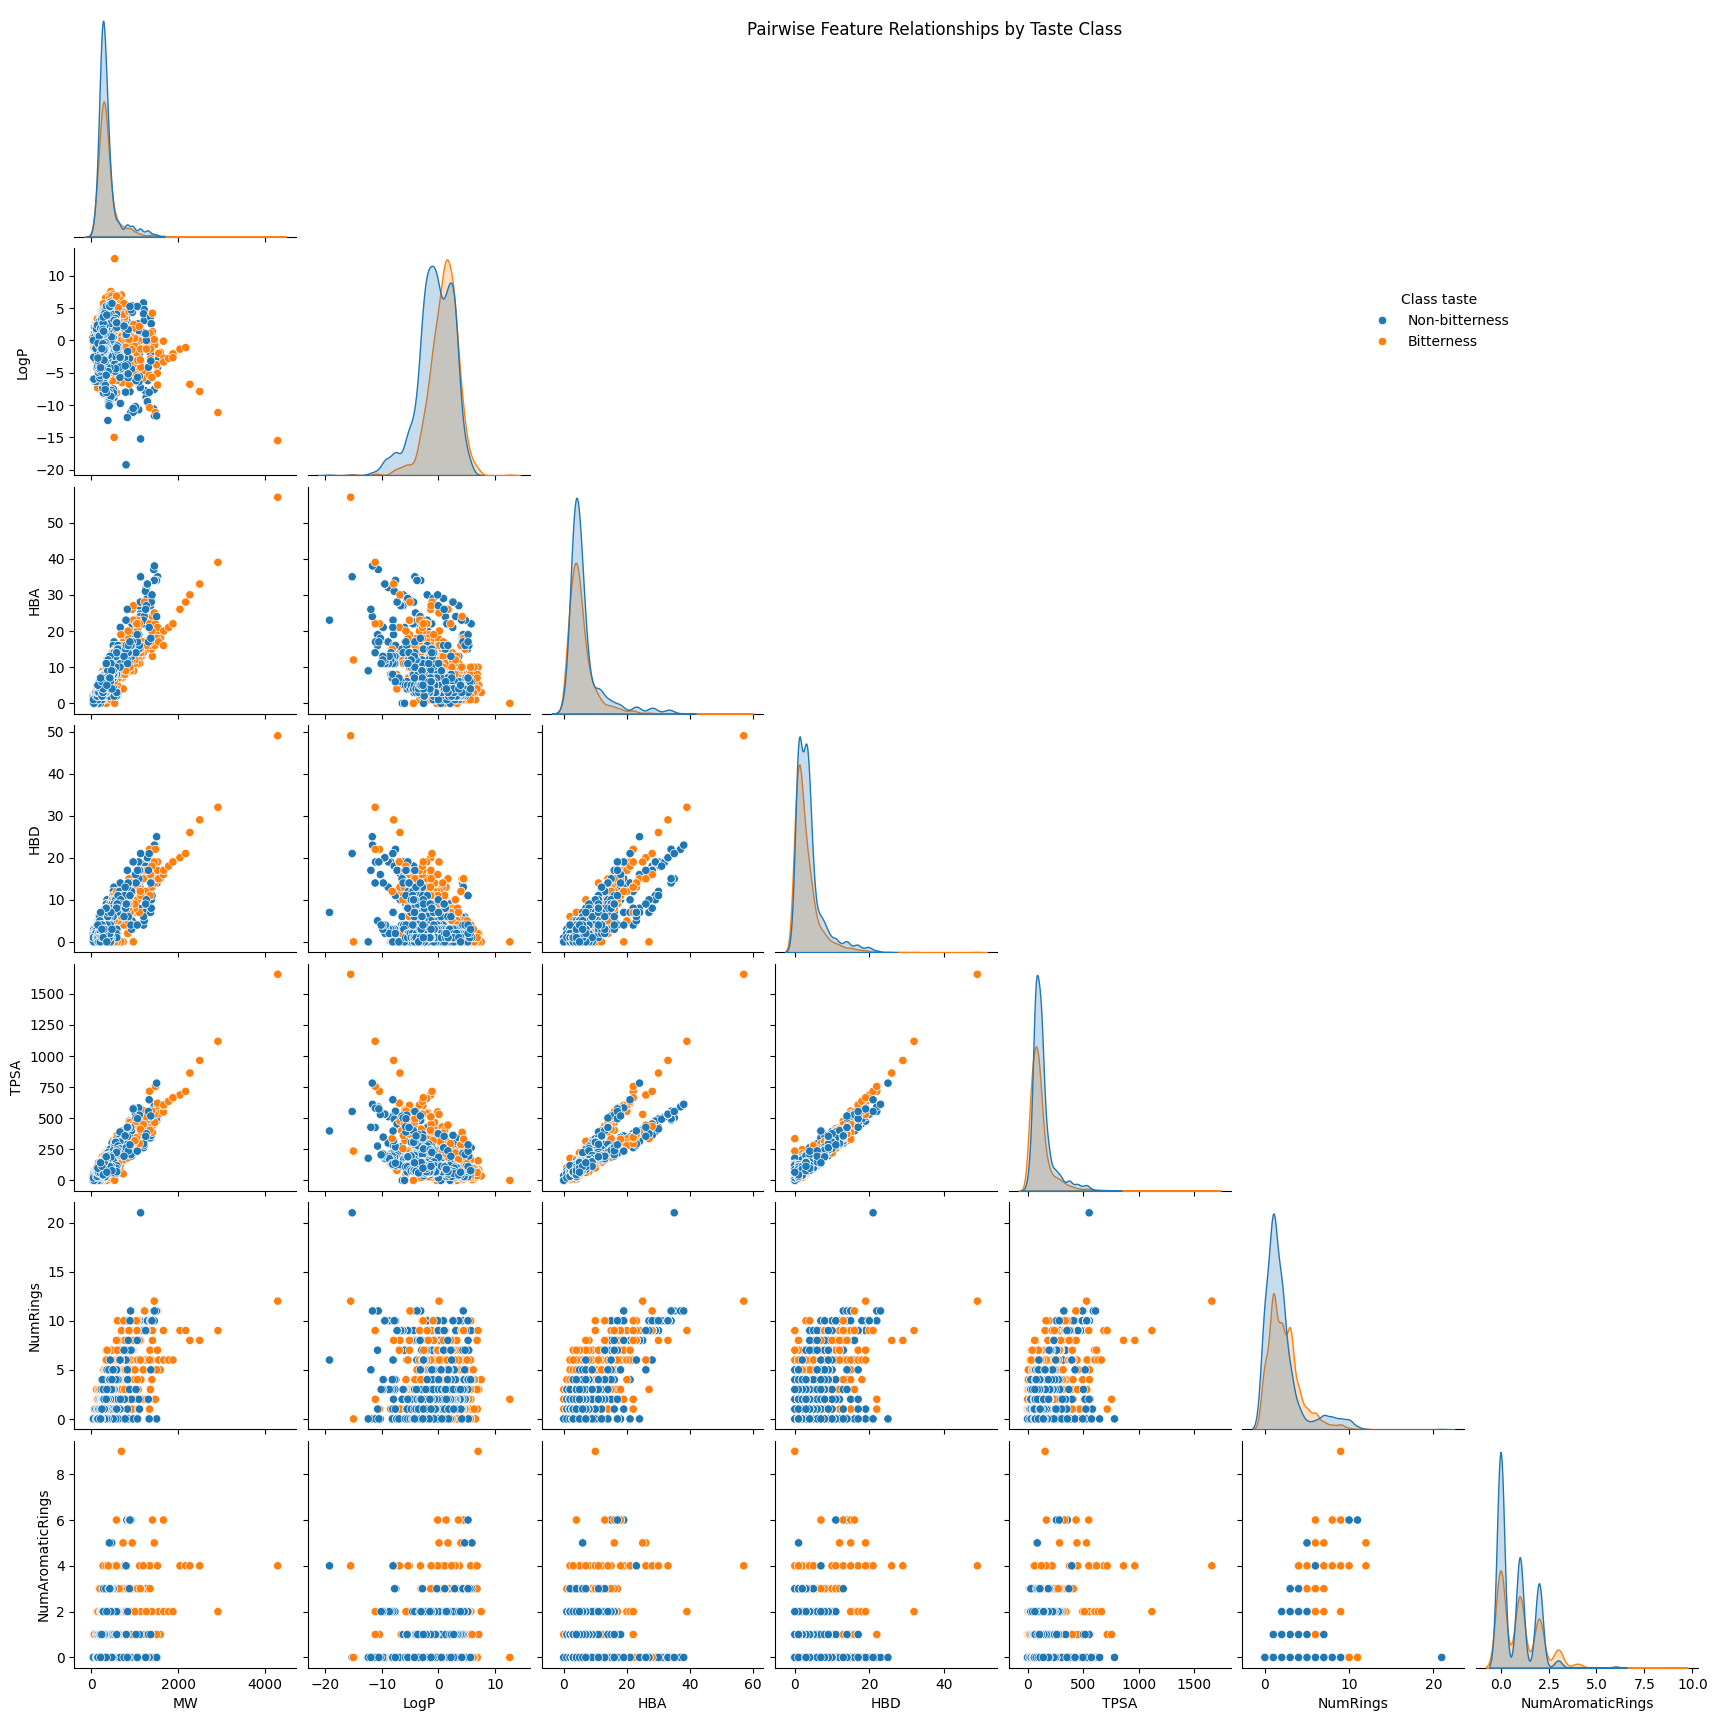

In [ ]:
plot = sns.pairplot(
    data=chemtastesdb_df_bitter,
    vars=["MW", "LogP", "HBA", "HBD", "TPSA", "NumRings", "NumAromaticRings"],
    hue="Class taste",
    corner=True
)

plot._legend.set_bbox_to_anchor((0.8, 0.8))
plt.suptitle("Pairwise Feature Relationships by Taste Class")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
labels = chemtastesdb_df_bitter["Class taste"]
features = chemtastesdb_df_bitter.drop(["Name", "canonical SMILES", "Class taste", "Element counts", "Functional group counts"], axis=1)

In [ ]:
feature_train, feature_test, label_train, label_test = train_test_split(
    features, labels, test_size=0.2, random_state=527
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(feature_train, label_train)

RandomForestClassifier()

In [ ]:
pred = rf_clf.predict(feature_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(label_test, pred, digits=3))

                precision    recall  f1-score   support

    Bitterness      0.840     0.813     0.827       337
Non-bitterness      0.853     0.876     0.865       419

      accuracy                          0.848       756
     macro avg      0.847     0.844     0.846       756
  weighted avg      0.848     0.848     0.848       756



In [ ]:
from collections import Counter

print(Counter(label_test))

Counter({'Non-bitterness': 419, 'Bitterness': 337})


In [ ]:
df = chemtastesdb_df_bitter[["Name", "canonical SMILES", "Class taste"]]

In [ ]:
df.to_csv("chemtastesdb_bitter")

In [7]:
# Check for metal elements
metals_to_remove = {
    'Li', 'Rb', 'Cs', 'Fr',
    'Be', 'Sr', 'Ba', 'Ra',
    'Al', 'Ga', 'In', 'Sn', 'Tl', 'Pb', 'Bi', 'Po',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
    'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn',
    'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
    'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr'
}

def contains_metal(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    
    for atom in mol.GetAtoms():
        element = atom.GetSymbol()
        if element in metals_to_remove:
            return True
    
    return False

In [8]:
metal_df = chemtastesdb_df.copy()
metal_df["contains_metal"] = metal_df["canonical SMILES"].apply(contains_metal)

In [9]:
df = metal_df[~metal_df["contains_metal"]].drop("contains_metal", axis=1)

In [10]:
df

,Name,canonical SMILES,Class taste
0,(-)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness
1,(+)-4β-hydroxyhernandulcin,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Sweetness
2,(+)-Dihydroquercetin 3-acetate,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Sweetness
3,(+)-Dihydro-6-methoxy-luteolin 3-acetate,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Sweetness
4,(+)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness
...,...,...,...
3951,D-Ribulose,OCC(O)C(O)C(=O)CO,Non-bitterness
3952,Fucoidan,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Non-bitterness
3953,Melibiose,OCC1OC(OCC2OC(O)C(O)C(O)C2O)C(O)C(O)C1O,Non-bitterness
3954,Rutamarin,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Non-bitterness


In [11]:
df = df.drop_duplicates(subset="canonical SMILES", keep="first")

In [12]:
df[["canonical SMILES", "Class taste"]].to_csv("../data/chemtastes_sanitized.csv", header=["smiles", "taste"], index=False)

In [13]:
def form_cat(taste):
    if taste == "Bitterness":
        return "Bitterness"
    elif taste == "Sweetness":
        return "Sweetness"
    else:
        return "Other"

df_three = df.copy()
df_three["Class taste"] = df["Class taste"].apply(form_cat)

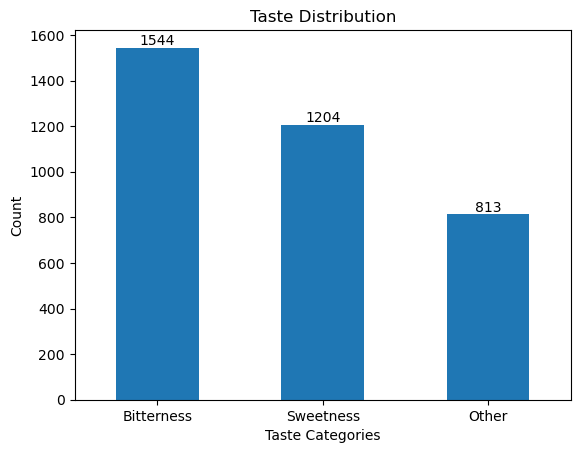

In [14]:
taste_count = df_three["Class taste"].value_counts()

ax = taste_count.plot(kind="bar", title="Taste Distribution")

for i, count in enumerate(taste_count):
    ax.text(i, count, str(count), ha="center", va="bottom")

ax.set_xlabel("Taste Categories")
ax.set_ylabel("Count")
ax.set_xticklabels(taste_count.index, rotation=0)

plt.show()

In [ ]:
df["canonical SMILES"].to_csv("../data/smiles.txt", index=False, header=False)

In [41]:
df

,Name,canonical SMILES,Class taste,inchi
0,(-)-Haematoxylin,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Sweetness,InChI=1S/C16H14O6/c17-10-2-1-8-13-9-4-12(19)11...
1,(+)-4β-hydroxyhernandulcin,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Sweetness,"InChI=1S/C15H24O3/c1-10(2)6-5-7-15(4,18)12-9-1..."
2,(+)-Dihydroquercetin 3-acetate,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Sweetness,InChI=1S/C17H14O8/c1-7(18)24-17-15(23)14-12(22...
3,(+)-Dihydro-6-methoxy-luteolin 3-acetate,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Sweetness,InChI=1S/C18H16O9/c1-7(19)26-18-15(24)13-12(6-...
5,(+)-Phyllodulcin 8-O-glucoside,COc1ccc(cc1O)C1Cc2cccc(c2C(=O)O1)OC1OC(CO)C(O)...,Sweetness,InChI=1S/C22H24O10/c1-29-13-6-5-10(7-12(13)24)...
...,...,...,...,...
3950,Bryodulcosigenin,CC(CCC(O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C...,Non-bitterness,"InChI=1S/C30H50O4/c1-18(9-13-24(32)27(4,5)34)1..."
3951,D-Ribulose,OCC(O)C(O)C(=O)CO,Non-bitterness,"InChI=1S/C5H10O5/c6-1-3(8)5(10)4(9)2-7/h3,5-8,..."
3952,Fucoidan,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Non-bitterness,InChI=1S/C7H14O7S/c1-3-5(8)6(9)7(4(2)13-3)14-1...
3954,Rutamarin,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Non-bitterness,"InChI=1S/C21H24O5/c1-7-20(3,4)15-9-13-8-14-10-..."


### Join Chemical Families

In [ ]:
family_df = pd.read_csv("../families.tsv", sep="\t")

In [17]:
family_df

,Identifier,Superclass,Class,Subclass
0,Oc1cc2c(cc1O)C1c3ccc(c(c3OCC1(O)C2)O)O,Organoheterocyclic compounds,Benzopyrans,1-benzopyrans
1,CC(C)=CCCC(C)(O)C1CC(O)C(=CC1=O)C,Lipids and lipid-like molecules,Prenol lipids,Sesquiterpenoids
2,CC(=O)OC1C(Oc2cc(cc(c2C1=O)O)O)c1ccc(c(c1)O)O,Phenylpropanoids and polyketides,Flavonoids,Flavans
3,COc1c(cc2c(c1O)C(=O)C(OC(C)=O)C(O2)c1ccc(c(c1)...,Phenylpropanoids and polyketides,Flavonoids,O-methylated flavonoids
4,COc1ccc(cc1O)C1Cc2cccc(c2C(=O)O1)OC1OC(CO)C(O)...,Organic oxygen compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates
...,...,...,...,...
3453,CC(CCC(O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C...,Lipids and lipid-like molecules,Steroids and steroid derivatives,Cucurbitacins
3454,OCC(O)C(O)C(=O)CO,Organic oxygen compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates
3455,CC1OC(C)C(OS(O)(=O)=O)C(O)C1O,Organoheterocyclic compounds,Oxanes,Unknown
3456,CC(=O)OC(C)(C)C1Cc2cc3c(cc2O1)OC(=O)C(=C3)C(C)...,Phenylpropanoids and polyketides,Coumarins and derivatives,Furanocoumarins


In [18]:
df[~df["canonical SMILES"].isin(family_df["Identifier"])]
family_df[~family_df["Identifier"].isin(df["canonical SMILES"])]

,Identifier,Superclass,Class,Subclass
18,N#Cc1ccc(NC(=NCC(=O)O)NC2CCCCCCC2)cc1,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
89,O=C(O)CN=C(Nc1ccccc1)Nc1ccccc1,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
96,N#Cc1ccc(NC(=NCC(=O)O)NCC23CC4CC(CC(C4)C2)C3)cc1,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
97,O=C(O)CN=C(Nc1cc(Cl)cc(Cl)c1)Nc1cccc2ccccc12,Benzenoids,Naphthalenes,Unknown
98,N#Cc1ccc(NC(=NCC(=O)O)NC2CCc3ccccc32)cc1,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
...,...,...,...,...
3164,CC(N)C(O)=NC1C(C)(C)SC1(C)C,Organoheterocyclic compounds,Thietanes,Unknown
3211,NC(=NCC(=O)O)Nc1ccccc1,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
3305,COC(=O)C(CC(=O)OC1CCCCC1)N=C(O)C(N)CC(=O)O,Organic acids and derivatives,Peptidomimetics,Hybrid peptides
3435,NC(N)=NC(Cc1c[nH]c2ccccc12)C(=O)O,Organoheterocyclic compounds,Indoles and derivatives,Indolyl carboxylic acids and derivatives


In [32]:
family_df["inchi"] = family_df["Identifier"].apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
df["inchi"] = df["canonical SMILES"].apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Proton(s) added/removed; Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39] WARNING: Omitted undefined stereo

[11:41:39

In [81]:
families = pd.merge(df, family_df, on='inchi', how='left')
families = families.drop_duplicates(subset="inchi", keep="first")

In [84]:
families[["canonical SMILES", "Class taste", "Superclass", "Class", "Subclass"]].to_csv("../data/chemtastes_families.csv",
                                                                                        header=["smiles", "taste", "superclass", "class", "subclass"], index=False)